In [1]:
import numpy as np
from tqdm import tqdm

from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

from scipy.optimize import minimize
from typing import Sequence

from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator

from qiskit_ibm_runtime.fake_provider import FakeFez

#import warnings
#warnings.filterwarnings('ignore', category=UserWarning, module='qiskit_ibm_runtime.fake_provider.local_service')

### 1. Use Qiskit Runtime to access real IBM device or use a Fake Backend

In [2]:
service = QiskitRuntimeService()

backend = FakeFez()
backend.name

management.get:WARNING:2025-11-18 15:21:20,528: Loading default saved account


'fake_fez'

In [20]:
# Input your credentials here to use real IBM Quantum backends

#QiskitRuntimeService.save_account(channel='ibm_quantum_platform', instance = '', token='', overwrite=True, set_as_default=True)
#service = QiskitRuntimeService(channel='ibm_quantum_platform')

#backend = service.least_busy(operational=True, simulator=False)
#backend = service.backend('ibm_kingston')  # Example for a specific backend
#backend.name

### 2. Choose system size and depth of ansatz. 
Then load the corresponding pre-optimized parameters (obtained from MPS simulations)

In [4]:
N = 50; J = 1.0; h = 1.0
chosen_depth = 3

'''# Load ED ground state data
ed = np.load(f"ED_data/gs_N{N}_J1.0_h1.0.npz")
gs_energy = ed['energy'
gs_state = ed['state']'''

'# Load ED ground state data\ned = np.load(f"ED_data/gs_N{N}_J1.0_h1.0.npz")\ngs_energy = ed[\'energy\'\ngs_state = ed[\'state\']'

In [6]:
data_from_sim = np.load(f'Hardware/experiment_params_N{N}_trotter{chosen_depth}.npz') #optimized_params/

depth = data_from_sim['depthKE']
zeta = data_from_sim['best_zeta']
num_edge_qubits = data_from_sim['num_edge_qubits']
opt_params_from_sim = data_from_sim['params_vqeKE']
opt_energy_from_sim = data_from_sim['energy_vqeKE']
fidelity_from_sim = data_from_sim['fidelity_vqeKE']
gate_count = data_from_sim['gate_count_KE']

print("Energy for ground state prep circuit without noise", opt_energy_from_sim)

Energy for ground state prep circuit without noise -1.236012740885024


### 3. Choosing a connected chain of desired length from hardware

In [7]:
coupling_map = backend.target.build_coupling_map()

def _adjacency(cm: CouplingMap, require_bidir: bool = False):
    """Undirected adjacency; if require_bidir=True keep only bidirectional CX edges."""
    edges = set(cm.get_edges())
    adj = {q: set() for q in cm.physical_qubits}
    for u, v in edges:
        if require_bidir and (v, u) not in edges:
            continue
        adj[u].add(v); adj[v].add(u)
    # drop isolated vertices (rare)
    return {q: nbs for q, nbs in adj.items() if nbs}

def find_open_chain(cm: CouplingMap, N: int, require_bidir: bool = False):
    """
    Find any simple path of N nodes (length N-1). Returns list of physical qubits or None.
    Also returns the longest path seen if exact N is impossible.
    """
    adj = _adjacency(cm, require_bidir=require_bidir)
    if N <= 1:
        # trivial
        for q in adj: 
            return [q], [q]
    # Prefer starting from degree-1 endpoints (good for chains), else all nodes
    endpoints = [q for q, nbs in adj.items() if len(nbs) == 1]
    starts = endpoints if endpoints else list(adj)

    best = []
    target = N

    # DFS with simple pruning
    for s in starts:
        stack = [(s, [s])]
        seen_starts = set()
        while stack:
            node, path = stack.pop()
            if len(path) > len(best):
                best = path
                if len(best) == target:  # found exact length
                    return best, best
            # Heuristic: expand neighbors with higher degree first
            nexts = sorted(adj[node] - set(path), key=lambda x: len(adj[x]), reverse=True)
            for nb in nexts:
                # Upper bound pruning: if even extending by all unused neighbors cannot reach target, skip
                if len(path) + (len(adj[nb]) or 1) < min(target, len(cm.physical_qubits)):
                    pass  # optional; keep simple
                stack.append((nb, path + [nb]))
        seen_starts.add(s)

    # No exact N found
    return None, best


chain, best = find_open_chain(coupling_map, N, require_bidir=False)

if chain is None:
    print(f"No {N}-qubit open chain found on {backend.name}. Longest found has {len(best)} qubits:", best)
    print(f"Cannot proceed with N={N}. Please choose a different N or backend.")
else:
    print(f"Successfully found {N}-qubit physical chain: {chain}")

Successfully found 50-qubit physical chain: [0, 1, 2, 3, 4, 5, 6, 7, 17, 27, 28, 29, 30, 31, 18, 11, 12, 13, 14, 15, 19, 35, 34, 33, 39, 53, 54, 55, 59, 75, 74, 73, 79, 93, 94, 95, 99, 115, 114, 113, 119, 133, 134, 135, 139, 155, 154, 153, 152, 151]


### 4. Build ansatz on the chosen chain
The ansatz utilizes the transaltional symmetry of the Hamiltonian

In [8]:
def _edge_center_layout_qiskit(N: int, num_edge_qubits: int):
    """
    funfcion to get layout - for OBC.
    """
    E = int(num_edge_qubits)
    assert 0 <= E <= N // 2, "num_edge_qubits must satisfy 0 <= E <= N//2"

    left_edge_qubits  = list(range(0, E))
    right_edge_qubits = list(range(N - E, N))
    center_qubits     = list(range(E, N - E))  # can be empty

    even_bonds = list(range(0, N - 1, 2))  # bonds (i, i+1) with even i
    odd_bonds  = list(range(1, N - 1, 2))  # bonds (i, i+1) with odd i

    def is_edge_bond(i):
        # bond (i, i+1) touches an edge site if i < E or (i+1) >= N - E
        return (i < E) or ((i + 1) >= (N - E))

    edge_even_bonds   = [i for i in even_bonds if is_edge_bond(i)]
    center_even_bonds = [i for i in even_bonds if not is_edge_bond(i)]

    edge_odd_bonds    = [i for i in odd_bonds if is_edge_bond(i)]
    center_odd_bonds  = [i for i in odd_bonds if not is_edge_bond(i)]

    return {
        "left_edge_qubits": left_edge_qubits,
        "center_qubits": center_qubits,
        "right_edge_qubits": right_edge_qubits,
        "edge_even_bonds": edge_even_bonds,
        "center_even_bonds": center_even_bonds,
        "edge_odd_bonds": edge_odd_bonds,
        "center_odd_bonds": center_odd_bonds,
    }


def params_per_layer(N: int, num_edge_qubits: int) -> int:
    """
    Count of scalars consumed per trotter layer under the sharing rule.
    """
    lay = _edge_center_layout_qiskit(N, num_edge_qubits)
    cnt_even = len(lay["edge_even_bonds"]) + (1 if len(lay["center_even_bonds"]) > 0 else 0)
    cnt_odd  = len(lay["edge_odd_bonds"])  + (1 if len(lay["center_odd_bonds"])  > 0 else 0)
    has_center = (len(lay["center_qubits"]) > 0)
    cnt_rx = len(lay["left_edge_qubits"]) + (1 if has_center else 0) + len(lay["right_edge_qubits"])
    return cnt_even + cnt_odd + cnt_rx


def total_params(N: int, trotter_steps: int, num_edge_qubits: int) -> int:
    return trotter_steps * params_per_layer(N, num_edge_qubits)


def qhd_start_transInv(N: int, trotter_steps: int, num_edge_qubits: int) -> np.ndarray:
    """
    per-layer vector of all-ones scaled by (π/2)*(layer/T)^3,
    concatenated over layers.
    """
    npl = params_per_layer(N, num_edge_qubits)
    chunks = []
    for layer in range(trotter_steps):
        scale = (np.pi / 2) * (layer / trotter_steps) ** 3
        chunks.append(np.ones(npl) * scale)
    return np.concatenate(chunks) if chunks else np.array([], dtype=float)


def build_variational_circuit_with_transInv(
    N: int,
    trotter_steps: int,
    angles: np.ndarray,
    num_edge_qubits: int,
    A: float,
    zeta: float,
) -> QuantumCircuit:
    """
    Parameter sharing & *within-layer* consumption order (identical to your docstring):
      [RZZ-even edge bonds (ascending i),
       RZZ-even center shared (if any),
       RZZ-odd  edge bonds (ascending i),
       RZZ-odd  center shared (if any),
       RX left-edge (ascending i),
       RX center shared (if any),
       RX right-edge (ascending i)]

    Gate-angle conventions mirror Quimb:
      - 'RZZ', 2*theta  ->  circuit.rzz(2*theta, i, j)
      - 'RX',  2*phi    ->  circuit.rx(2*phi, q)
      - 'RY',  2*ke     ->  circuit.ry(2*ke, q)
    """
    lay = _edge_center_layout_qiskit(N, num_edge_qubits)
    qc = QuantumCircuit(N)

    # Initial H layer
    for q in range(N):
        qc.h(q)

    idx = 0
    for layer in range(trotter_steps):

        # ---- RZZ EVEN sublayer ----
        for i in lay["edge_even_bonds"]:
            theta = angles[idx]; idx += 1
            qc.rzz(2 * theta, i, i + 1)
        if len(lay["center_even_bonds"]) > 0:
            theta_center_even = angles[idx]; idx += 1
            for i in lay["center_even_bonds"]:
                qc.rzz(2 * theta_center_even, i, i + 1)

        # ---- RZZ ODD sublayer ----
        for i in lay["edge_odd_bonds"]:
            theta = angles[idx]; idx += 1
            qc.rzz(2 * theta, i, i + 1)
        if len(lay["center_odd_bonds"]) > 0:
            theta_center_odd = angles[idx]; idx += 1
            for i in lay["center_odd_bonds"]:
                qc.rzz(2 * theta_center_odd, i, i + 1)

        # ---- RX single-qubit layer ----
        for q in lay["left_edge_qubits"]:
            phi = angles[idx]; idx += 1
            qc.rx(2 * phi, q)
        if len(lay["center_qubits"]) > 0:
            phi_center = angles[idx]; idx += 1
            for q in lay["center_qubits"]:
                qc.rx(2 * phi_center, q)
        for q in lay["right_edge_qubits"]:
            phi = angles[idx]; idx += 1
            qc.rx(2 * phi, q)

        # ---- Kinetic term layer ----
        ke_angle = A * np.exp(-zeta * layer)
        if (layer != trotter_steps - 1) and (ke_angle > 1e-3):
            for q in range(N):
                qc.ry(2 * ke_angle, q)

    # Safety check
    if idx != len(angles):
        raise ValueError(
            f"Angle vector length mismatch: consumed {idx}, provided {len(angles)} "
            f"(N={N}, trotter_steps={trotter_steps}, num_edge_qubits={num_edge_qubits})."
        )

    return qc

In [9]:
ansatz_problem_tailored = build_variational_circuit_with_transInv(
    N=N,
    trotter_steps=depth,
    angles=opt_params_from_sim,
    num_edge_qubits=num_edge_qubits,
    A=np.pi/2,
    zeta=zeta,
)

#ansatz_problem_tailored.draw('mpl', fold=-1)

### 5. Transpile circuit for chosen hardware

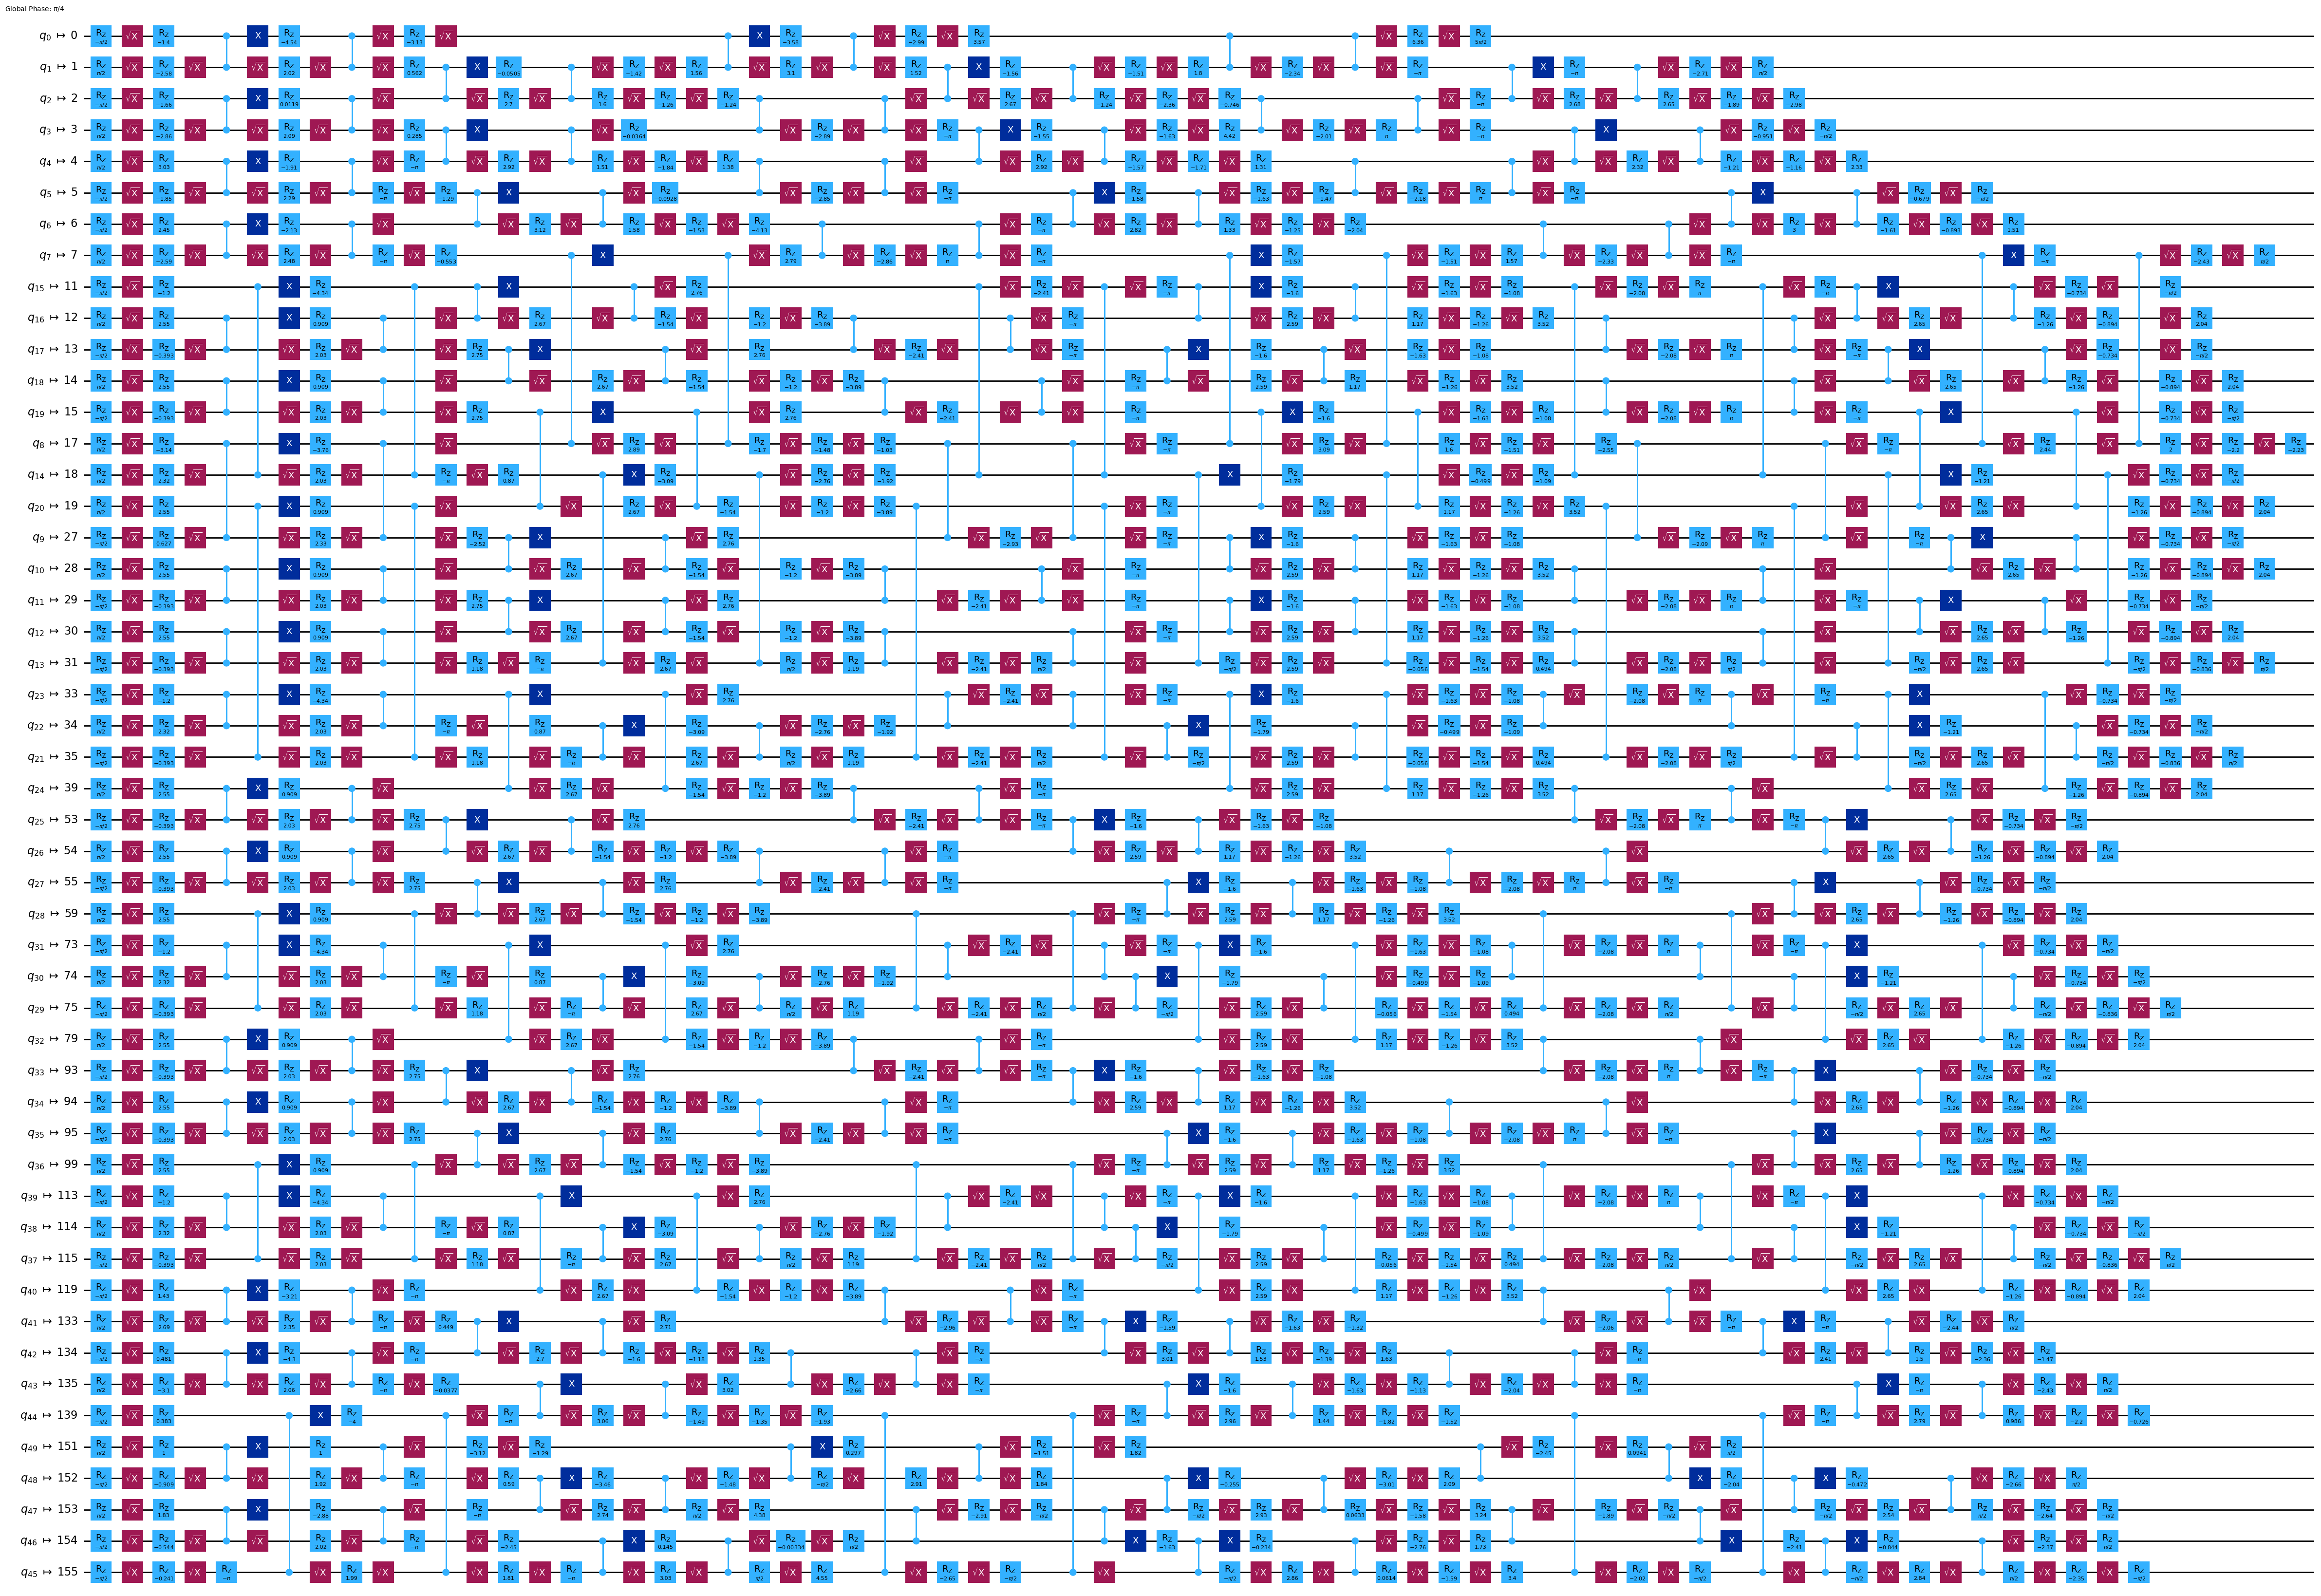

In [11]:
# ----------------------------------------------------------------------
# 3. TRANSPILE THE LOGICAL CIRCUIT ONTO THE PHYSICAL CHAIN

# Tell the transpiler to map your logical circuit (0...N-1)
# to the physical qubits specified in 'chain'.
# (i.e., logical 0 -> chain[0], logical 1 -> chain[1], ...)

ansatz_ibm = transpile(
    ansatz_problem_tailored, 
    backend=backend, 
    initial_layout=chain,
    optimization_level=3,
    scheduling_method=None 
)

ansatz_ibm.draw('mpl', fold=-1, idle_wires=False)

### 5. Define the measurement observable - the target Hamiltonian

In [12]:
def build_physical_hamiltonian_on_chain(
    physical_chain: list[int], 
    total_device_qubits: int, 
    J: float = 1.0, 
    h: float = 1.0
) -> SparsePauliOp:
    """
    Builds the TFIM Hamiltonian SparsePauliOp directly on the
    specified physical qubits.
    
    Args:
        physical_chain: The list of physical qubit indices (e.g., [4, 7, 10]).
        total_device_qubits: The total number of qubits on the backend (e.g., 127).
        J: ZZ coupling strength.
        h: X field strength.
    """
    terms = []
    
    # Add ZZ terms for adjacent qubits in the physical chain
    for i in range(len(physical_chain) - 1):
        q1 = physical_chain[i]
        q2 = physical_chain[i+1]
        # Build the term on the physical qubit indices
        terms.append(('ZZ', [q1, q2], -J))
             
    # Add X terms for ALL qubits in the physical chain
    for q in physical_chain:
        # Build the term on the physical qubit index
        terms.append(('X', [q], -h))
        
    # Create the operator defined over the full device
    return SparsePauliOp.from_sparse_list(terms, num_qubits=total_device_qubits)

In [13]:
# Get the total number of qubits on the backend
total_qubits = backend.target.num_qubits

# Build the observable. This is our final, physical observable.
observable_ibm = build_physical_hamiltonian_on_chain(
    physical_chain=chain, 
    total_device_qubits =total_qubits, 
    J=J, 
    h=h
)

### 6. Calculate expectation value in the prepared ground state!

In [ ]:
with Session(backend=backend) as session:
    estimator = Estimator()
    estimator.options.default_shots = 4000

    result = estimator.run([(ansatz_ibm, observable_ibm)]).result()
    print(result)
    pub = result[0]
    energy_noisy   = float(pub.data.evs)
    sigma  = float(pub.data.stds)                   # per-shot std of the estimator
    stderr = float(pub.data.ensemble_standard_error)  # std / sqrt(effective_shots)
print(f"E/N = {energy_noisy/N:.6f} ± {stderr/N:.6f} (stderr), shots={pub.metadata['shots']}")